In [4]:
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

import text_processing
import unsupervised

%matplotlib inline

In [5]:
# load data
articles = pickle.load(open('articles_df.pickle', 'rb'))
articles_cv = pickle.load(open('articles_doc_term_CV.pickle', 'rb'))
articles_tfidf = pickle.load(open('articles_doc_term_TFIDF.pickle', 'rb'))

In [6]:
# how many spam and valid articles are there in the dataset?
articles.groupby('spam').text.count()

spam
False    463
True     168
Name: text, dtype: int64

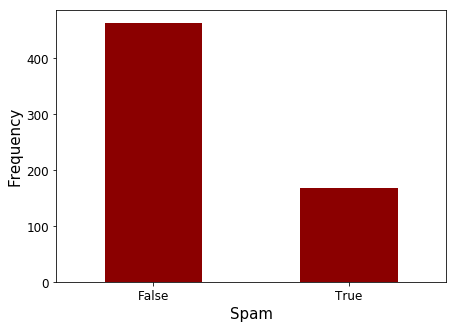

In [7]:
# barplot of the class counts highlighting class imbalance
plt.figure(figsize = (7, 5))
articles['spam'].value_counts().plot.bar(color = 'darkred')
plt.xlabel('Spam', fontsize = 15)
plt.ylabel('Frequency', fontsize = 15)
plt.xticks(fontsize = 12, rotation = 0)
plt.yticks(fontsize = 12)
plt.savefig('spam_counts.png', dpi = 100, bbox_inches = 'tight')
plt.show()
plt.close()

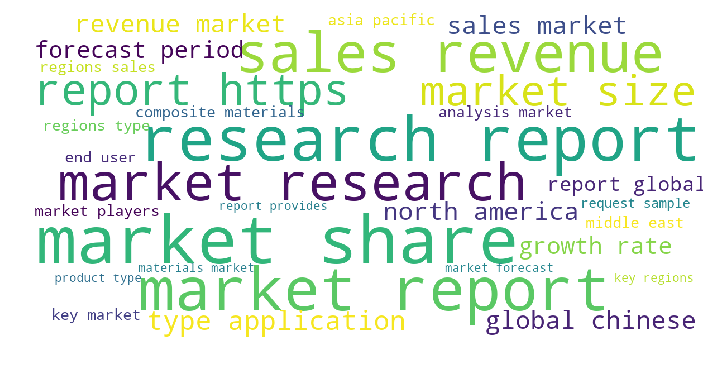

In [8]:
# word cloud showing the 30 most common words in spam articles
text_processing.display_wordcloud(articles.loc[articles.spam == True, 'text'].values.tolist(), 
                                  bg_color = 'white', max_words = 30, file = 'spam_exploratory_wc.png', 
                                  prefer_horizontal = 1)

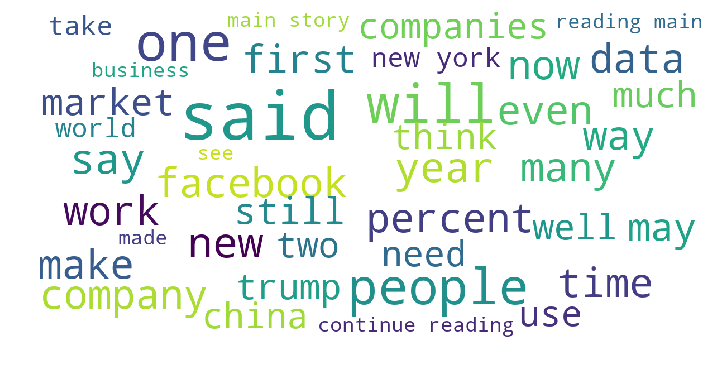

In [9]:
# word cloud showing the 30 most common words in valid articles
text_processing.display_wordcloud(articles.loc[articles.spam == False, 'text'].values.tolist(), 
                                  bg_color = 'white', max_words = 40, file = 'non_spam_exploratory_wc.png', 
                                  prefer_horizontal = 1)

In [10]:
# split the Count Vectorizer document-term matrix into training and test sets (50-50 split)
X_train, X_test, y_train, y_test = train_test_split(articles_cv, articles['spam'], test_size = 0.5, 
                                                    random_state = 2, stratify = articles['spam'])

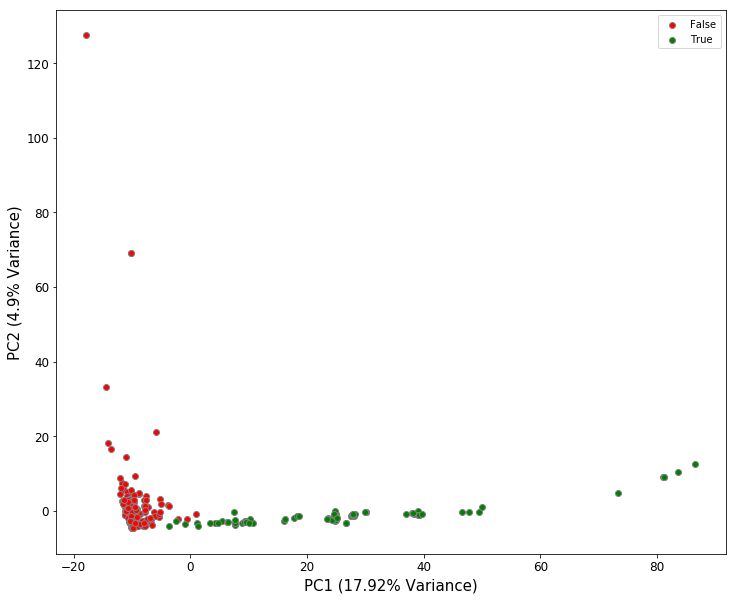

In [11]:
# plot PCA scores from training set on PC1 and PC2 colored by spam category to see if there is separation
# PC1 seems to separate spam from valid articles well
unsupervised.plot_PCA_2D(df = X_train, groups = y_train, group_labels = [False, True], 
                         random_state = 2, file = 'pca_scores_train.png')

In [12]:
# center and scale training data, fit PCA model, and extract PC scores
ss = StandardScaler(with_std = False).fit(X_train)
X_train_ss = ss.transform(X_train)
X_train_pca = PCA(random_state = 2).fit(X_train_ss)
X_train_scores = X_train_pca.transform(X_train_ss)

In [13]:
# how many PCs needed to explain 90% of the variance in the training data?
np.min(np.where(np.cumsum(X_train_pca.explained_variance_ratio_) >= 0.9))

130

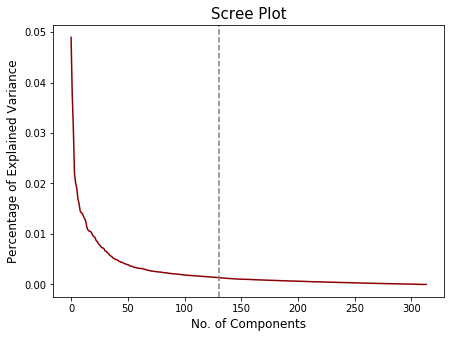

In [14]:
# Scree plot with vertical line drawn at 130 PCs
plt.figure(figsize = (7, 5))
plt.plot(X_train_pca.explained_variance_ratio_[1:], color = 'darkred')
plt.axvline(130, color = 'gray', linestyle = '--')
plt.xlabel('No. of Components', fontsize = 12)
plt.ylabel('Percentage of Explained Variance', fontsize = 12);
plt.title('Scree Plot', fontsize = 15)
plt.savefig('scree.png', dpi = 100, bbox_inches = 'tight')
plt.show()
plt.close()

In [15]:
# extract PC loadings to explore important features
X_train_loadings = pd.DataFrame(X_train_pca.components_, columns = X_train.columns)
X_train_loadings.shape

(315, 20946)

In [16]:
# PC1 seems to do a good job of separating spam from non-spam, so look at loadings to see highly-weighted words
print('Spam Words:', '\n\n', X_train_loadings.iloc[0, :].sort_values(ascending = False)[0:25], '\n')
print('Non-Spam Words:', '\n\n', X_train_loadings.iloc[0, :].sort_values(ascending = True)[0:25])

Spam Words: 

 market          0.768567
report          0.293239
global          0.211250
industry        0.182419
analysis        0.127564
sales           0.121594
regions         0.109287
key             0.106702
chapter         0.095589
research        0.092685
revenue         0.088970
share           0.085186
chinese         0.074644
product         0.072134
forecast        0.064947
growth          0.062828
type            0.060127
application     0.059541
information     0.057733
production      0.051278
https           0.049007
com             0.048640
applications    0.047000
players         0.045585
press           0.044196
Name: 0, dtype: float64 

Non-Spam Words: 

 said        -0.057718
people      -0.036796
time        -0.022765
like        -0.022198
trump       -0.020221
facebook    -0.019442
just        -0.018994
year        -0.017905
years       -0.017263
don         -0.016045
instagram   -0.015914
says        -0.015553
percent     -0.015022
story       -0.014689
think  

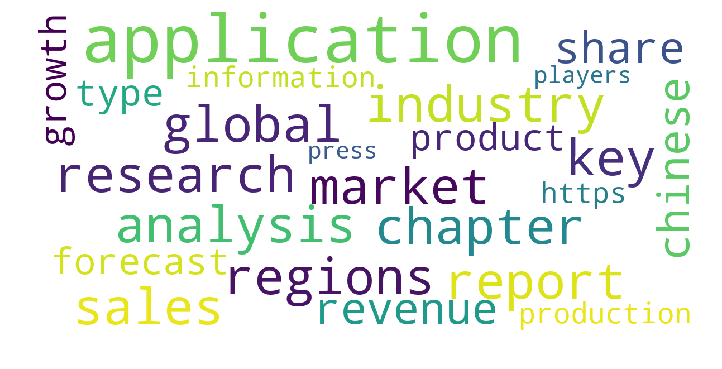

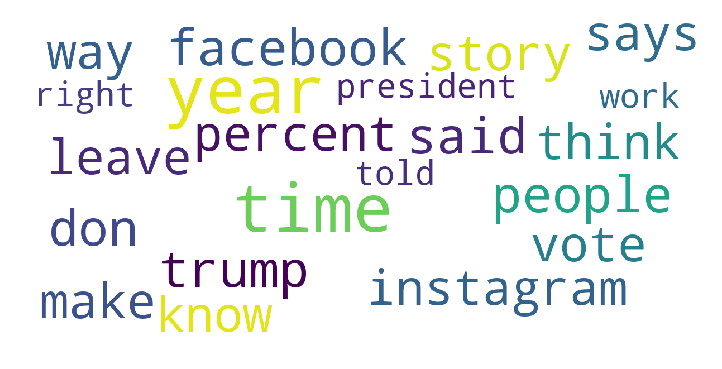

In [17]:
# word clouds of highly-weighted spam words (positive loadings) and non-spam words (negative loadings)
text_processing.display_wordcloud(' '.join(X_train_loadings.iloc[0, :]\
                                           .sort_values(ascending = False)[0:25].index.tolist()), 
                                  bg_color = 'white', max_words = 25, prefer_horizontal = 0.95, 
                                  file = 'spam_PCA_wc.png')
text_processing.display_wordcloud(' '.join(X_train_loadings.iloc[0, :]\
                                           .sort_values(ascending = True)[0:25].index.tolist()), 
                                  bg_color = 'white', max_words = 25, prefer_horizontal = 0.95, 
                                  file = 'no_spam_PCA_wc.png')

In [18]:
# take scores from the top 130 PCs as a new dataset
X_train2 = X_train_scores[:, 0:130]
y_train2 = y_train.copy()

In [19]:
# apply same scaling and PCA fit that was done to the training set to the test set
X_test2 = ss.transform(X_test)
X_test2 = X_train_pca.transform(X_test2)[:, 0:130]
y_test2 = y_test.copy()
X_test2.shape

(316, 130)

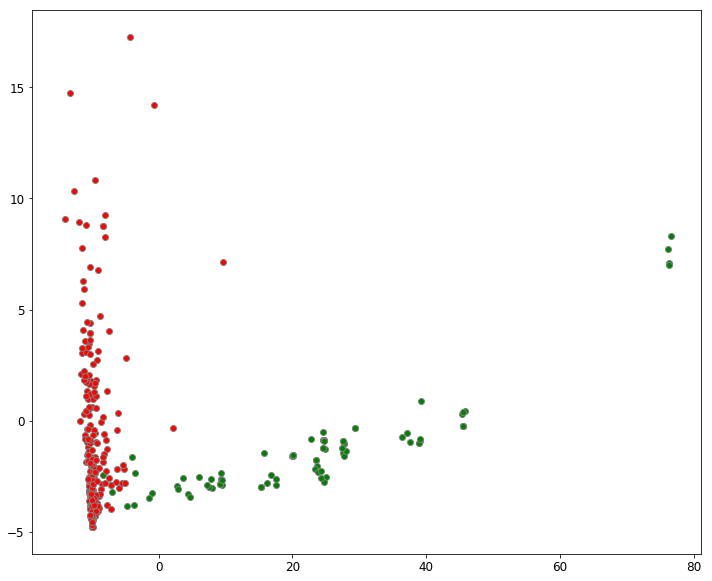

In [20]:
# project scores from test set PCA onto the first 2 PCs
plt.figure(figsize = (12, 10))
plt.scatter(X_test2[y_test2, 0], X_test2[y_test2, 1], c = 'g', edgecolors = 'gray')
plt.scatter(X_test2[~y_test2, 0], X_test2[~y_test2, 1], c = 'r', edgecolors = 'gray')
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.savefig('pca_scores_test.png', dpi = 100, bbox_inches = 'tight')
plt.show()
plt.close()

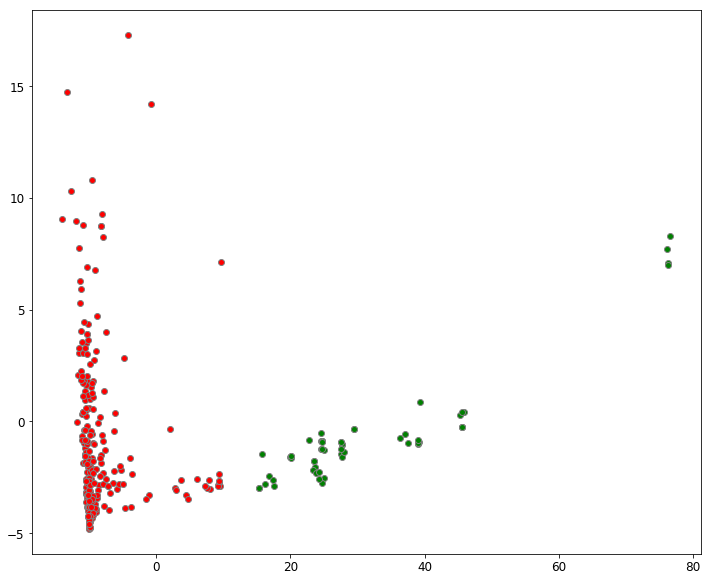

In [21]:
# perform K-Means cluster analysis on test set PC scores (with k = 2) to see how data naturally splits
# generally good agreement between cluster assignments and spam class label (above)
X_test2_km = KMeans(n_clusters = 2, init = 'k-means++', n_init = 10, random_state = 2, n_jobs = -1)
X_test2_km.fit(X_test2)
unsupervised.display_clusters(X_test2, X_test2_km, num_clusters = 2, file = 'kmeans.png')

In [22]:
# which spam articles did not cluster with the others using K-Means on the PC scores?
articles.iloc[X_test[X_test2_km.labels_ != y_test2].index.tolist(), :]

,text,link,spam
494,wimax solution market emphasized undergo signi...,https://www.satprnews.com/2018/03/25/wimax-sol...,True
583,the global inclination sensors market report o...,https://www.highlandmirror.com/2018-03-20-glob...,True
521,hydroxypropyl cellulose kind cellulose ether w...,https://www.satprnews.com/2018/03/25/hydroxypr...,True
490,marketing automation accredits software tools ...,https://www.satprnews.com/2018/03/25/steady-gr...,True
509,propertyup barrington excited announce new res...,https://www.satprnews.com/2018/03/25/property-...,True
580,the global pilates studio software market repo...,https://www.highlandmirror.com/2018-03-20-glob...,True
529,geogrids are class geosynthetics which are com...,https://www.satprnews.com/2018/03/25/geogrids-...,True
532,the prevailing passive economic growth china c...,https://www.satprnews.com/2018/03/25/3-2-cagr-...,True
515,esters are the chemical compound and are deriv...,https://www.satprnews.com/2018/03/25/polyols-e...,True
496,terminal with contactless functionality suppo...,https://www.satprnews.com/2018/03/25/rising-aw...,True


In [25]:
# export train and test sets constructed from PC scores
pickle.dump(X_train2, open('PCA_scores_train.pickle', 'wb'))
pickle.dump(X_test2, open('PCA_scores_test.pickle', 'wb'))
pickle.dump(y_train2, open('spam_category_train.pickle', 'wb'))
pickle.dump(y_test2, open('spam_category_test.pickle', 'wb'))